# 中文短文本分类

## 1 基线

- 数据：类别较为不均衡，且无数据增强
- 模型：BertForSequenceClassification【RoBERTa(encoder*12) + Dropout(0.1) + Linear(768,14)】
- 微调方案：
    - 全量微调
    - 超参数：
        - lr = 4e-5
            - 线性预热*0.1 + 线性退火*0.9（逐批次）
        - epochs = 4
        - weight_decay = 0.01
- 准确率：88.78814
- 显存占用：约为 9G

## 2 数据分析与处理

UTF-8 纯文本格式。

14个候选分类类别：财经、彩票、房产、股票、家居、教育、科技、社会、时尚、时政、体育、星座、游戏、娱乐。

训练数据共832471条。

比赛提供数据集的格式：训练集和验证集格式：原文标题+\t+标签，测试集格式：原文标题。

===== 加载数据集 =====

In [ ]:
import pandas as pd

# 使用pandas读取数据集
train = pd.read_table('./data/news_datasets/train.txt', sep='\t', header=None)  # 训练集
dev = pd.read_table('./data/news_datasets/dev.txt', sep='\t', header=None)  # 验证集
test = pd.read_table('./data/news_datasets/test.txt', sep='\t', header=None)  # 测试集

# 添加列名便于对数据进行更好处理
train.columns = ["text_a",'label']
dev.columns = ["text_a",'label']
test.columns = ["text_a"]

In [ ]:
print(train)

                           text_a label
0                 网易第三季度业绩低于分析师预期    科技
1       巴萨1年前地狱重现这次却是天堂 再赴魔鬼客场必翻盘    体育
2              美国称支持向朝鲜提供紧急人道主义援助    时政
3                增资交银康联 交行夺参股险商首单    股票
4                    午盘：原材料板块领涨大盘    股票
...                           ...   ...
752466     天津女排奇迹之源竟在场边 他是五冠王真正核心    体育
752467       北电网络专利拍卖推迟：可能分拆6部分拍卖    科技
752468  Spirit AeroSystems债券发行价确定    股票
752469    陆慧明必发火线：法兰克福无胜 曼联国米顺利过关    彩票
752470       首破万元 索尼46寸全新LED液晶特价促    科技

[752471 rows x 2 columns]


In [ ]:
print(dev)

                         text_a label
0      网民市民集体幻想中奖后如果你中了9000万怎么办    彩票
1                   PVC期货有望5月挂牌    财经
2              午时三刻新作《幻神录―宿命情缘》    游戏
3          欧司朗LLFY网络提供一站式照明解决方案    家居
4         试探北京楼市向何方：排不完的队　涨不够的价    房产
...                         ...   ...
79995  王大雷看国足比赛预测比分我觉得是2-0或者3-1    体育
79996   克雷扎回归猛龙势如破竹希尔遭驱逐太阳惨败51分    体育
79997           王建宙将与台商共创4G网络商机    科技
79998      普京突访食品超市做调查不满高价猪肉(图)    时政
79999        高空俯视女明星性感乳沟(组图)(7)    时尚

[80000 rows x 2 columns]


In [ ]:
print(test)

                            text_a
0          北京君太百货璀璨秋色 满100省353020元
1                教育部：小学高年级将开始学习性知识
2            专业级单反相机 佳能7D单机售价9280元
3              星展银行起诉内地客户 银行强硬客户无奈
4           脱离中国的实际 强压人民币大幅升值只能是梦想
...                            ...
83594        Razer杯DotA精英挑战赛8月震撼登场
83595              经济数据好转吹散人民币贬值预期
83596         抵押率抵押物双控政策 刘明康支招房产贷款
83597  8000万像素 利图发布Aptus-II 12数码后背
83598          教育部公布33个国家万余所正规学校名单

[83599 rows x 1 columns]


===== 数据统计与分析 ===== 

In [ ]:
# 拼接训练和验证集，便于统计分析
total = pd.concat([train,dev],axis=0)

# 总类别标签分布统计
print(total['label'].value_counts())

label
科技    162245
股票    153949
体育    130982
娱乐     92228
时政     62867
社会     50541
教育     41680
财经     36963
家居     32363
游戏     24283
房产     19922
时尚     13335
彩票      7598
星座      3515
Name: count, dtype: int64


<Axes: xlabel='label'>

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25216 (\N{CJK UNIFIED IDEOGRAPH-6280}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


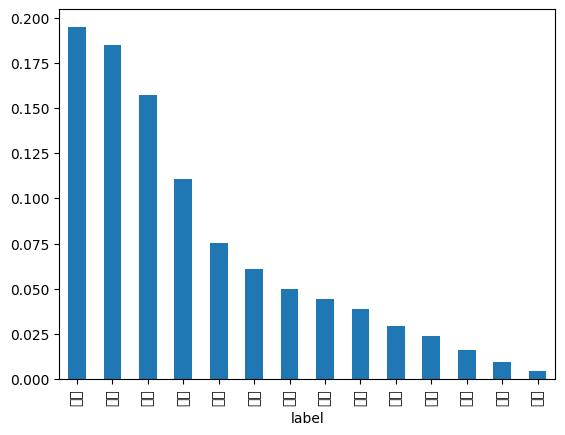

In [ ]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

# 设置显示中文
# matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体
# matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 设置字体大小
# matplotlib.rcParams['font.size'] = 16

# 可视化类别标签分布情况
total['label'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
# 文本长度统计分析,通过分析可以看出文本较短，最长为48
print(total['text_a'].map(len).describe())

count    832471.000000
mean         19.388112
std           4.097139
min           2.000000
25%          17.000000
50%          20.000000
75%          23.000000
max          48.000000
Name: text_a, dtype: float64


In [ ]:
# 对测试集的长度统计分析，可以看出在长度上分布与训练数据相近
print(test['text_a'].map(len).describe())

count    83599.000000
mean        19.815022
std          3.883845
min          3.000000
25%         17.000000
50%         20.000000
75%         23.000000
max         84.000000
Name: text_a, dtype: float64


In [ ]:
# 保存处理后的数据集文件
train.to_csv('./data/news_datasets/train.csv', sep='\t', index=False)  # 保存训练集，格式为text_a,label
dev.to_csv('./data/news_datasets/dev.csv', sep='\t', index=False)      # 保存验证集，格式为text_a,label
test.to_csv('./data/news_datasets/test.csv', sep='\t', index=False)    # 保存测试集，格式为text_a

In [ ]:
# 定义要进行分类的14个类别
label_list=list(train.label.unique())
print(label_list)

['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']


## 3 训练

### 3.1 数据集构建

In [ ]:
# 类别列表
# label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

In [ ]:
# ---------------------- 1. 自动提取14个类别标签（无需手动定义） ----------------------
# def get_label_list(train_csv_path="./data/news_datasets/train.csv"):
#     """从训练集CSV中自动提取所有唯一标签，生成label_list和标签映射"""
#     if not os.path.exists(train_csv_path):
#         raise FileNotFoundError(f"训练集文件 {train_csv_path} 不存在，请检查路径")
    
#     # 读取训练集，获取所有标签
#     train_df = pd.read_csv(train_csv_path, sep='\t')  # 按制表符分隔
#     label_list = train_df['label'].unique().tolist()  # 自动提取唯一标签
#     label2id = {label: idx for idx, label in enumerate(label_list)}  # 标签→ID映射
#     id2label = {idx: label for idx, label in enumerate(label_list)}  # ID→标签映射
    
#     print(f"共提取到 {len(label_list)} 个类别：{label_list}")
#     return label_list, label2id, id2label

# label_list, label2id, id2label = get_label_list()
# print(label_list)
# print(label2id)
# print(id2label)

In [ ]:
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

In [ ]:
# ---------------------- 2. 数据集类（适配CSV文件，兼容训练/验证集） ----------------------
class NewsDataset(Dataset):
    def __init__(self, csv_path, tokenizer, label2id, max_seq_length=48):
        """
        Args:
            csv_path: 数据集CSV文件路径（train.csv/dev.csv）
            tokenizer: BertTokenizer实例
            label2id: 标签→ID映射字典
            max_seq_length: 文本最大截断/补全长度（按你的分析设为48）
        """
        # 读取CSV文件（制表符分隔，第一行为表头）
        self.df = pd.read_csv(csv_path, sep='\t')
        # 过滤无效数据（确保text_a和label列存在且非空）
        self.df = self.df.dropna(
            subset=['text_a', 'label']).reset_index(drop=True)

        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_seq_length = max_seq_length

    def __len__(self):
        """返回数据集总条数"""
        return len(self.df)

    def __getitem__(self, idx):
        """按索引获取单条数据，完成Tokenize和标签转换"""
        # 提取文本和标签
        text_a = self.df.iloc[idx]['text_a'].strip()
        label = self.df.iloc[idx]['label'].strip()

        # Tokenize处理（生成input_ids、attention_mask、token_type_ids）
        encoding = self.tokenizer(
            text_a,
            max_length=self.max_seq_length,
            padding=False,  # 暂不padding，在collate_fn中统一处理（更高效）
            truncation=True,
            return_tensors=None  # 返回列表格式，方便后续pad
        )

        # 标签转换为ID（数值型）
        label_id = self.label2id[label]

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(encoding['token_type_ids'], dtype=torch.long),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }

In [ ]:
# ---------------------- 3. 自定义Collate_fn（将一个批次内的所有样本，统一处理成该批次内的 “最长样本长度”） ----------------------
# 模型要求：神经网络需要 “同批次样本长度一致” 才能并行计算（否则无法矩阵运算），所以必须统一批次内的长度
# 显存优化：如果不管样本实际长度，都强制补到max_seq_length，会导致大量短样本被补无用的 padding，浪费显存；而按 “批次最长长度” 补，能最大限度减少无用 padding，节省显存
def collate_fn(batch_samples, pad_token_id=0):
    """
    批次数据处理：将单个样本拼接成批次，统一补全padding
    对应Paddle中的batchify_fn功能
    """
    # 提取批次中各字段的列表
    input_ids_list = [sample['input_ids'] for sample in batch_samples]
    attention_mask_list = [sample['attention_mask'] for sample in batch_samples]
    token_type_ids_list = [sample['token_type_ids'] for sample in batch_samples]
    labels_list = [sample['labels'] for sample in batch_samples]
    
    # 对序列进行padding（按批次中最长序列对齐）
    padded_input_ids = pad_sequence(
        input_ids_list, batch_first=True, padding_value=pad_token_id
    )
    padded_attention_mask = pad_sequence(
        attention_mask_list, batch_first=True, padding_value=0  # attention_mask pad 0
    )
    padded_token_type_ids = pad_sequence(
        token_type_ids_list, batch_first=True, padding_value=0  # token_type_ids pad 0
    )
    # 标签拼接成批次
    batch_labels = torch.stack(labels_list, dim=0)
    
    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_mask,
        'token_type_ids': padded_token_type_ids,
        'labels': batch_labels
    }

In [ ]:
# ---------------------- 4. DataLoader构建（对应Paddle的create_dataloader） ----------------------
def create_dataloader(
    csv_path, tokenizer, label2id, max_seq_length=48, batch_size=256, mode='train'
):
    """
    构建DataLoader迭代器
    Args:
        mode: 'train'（训练集，打乱）/'dev'（验证集，不打乱）
    """
    # 构建数据集实例
    dataset = NewsDataset(
        csv_path=csv_path,
        tokenizer=tokenizer,
        label2id=label2id,
        max_seq_length=max_seq_length
    )
    
    # 构建Sampler（训练集打乱，验证集不打乱）
    shuffle = True if mode == 'train' else False
    
    # 构建DataLoader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,  # 自定义批次处理函数
        num_workers=2,  # 多线程加载（根据CPU核心数调整，0为单线程）
        pin_memory=True  # 加速GPU训练（如果使用GPU）
    )
    
    return dataloader

### 3.2 准备工作

In [ ]:
from transformers import BertTokenizer

# 初始化Tokenizer（与本地BERT模型匹配）
tokenizer = BertTokenizer.from_pretrained("./models/chinese-roberta-wwm-ext")

# 参数设置（对齐Paddle流程）
batch_size = 256  # 可根据显存调整（如128、64）
max_seq_length = 48  # 按文本长度分析结果设置

# 固定随机种子便于结果的复现
seed = 1024
# random.seed(seed)  # Python 原生随机数
np.random.seed(seed)  # NumPy 随机数
torch.manual_seed(seed)  # PyTorch CPU 随机数种子

# 构建训练集和验证集DataLoader
train_dataloader = create_dataloader(
    csv_path="./data/news_datasets/train.csv",
    tokenizer=tokenizer,
    label2id=label2id,
    max_seq_length=max_seq_length,
    batch_size=batch_size,
    mode='train'
)

dev_dataloader = create_dataloader(
    csv_path="./data/news_datasets/dev.csv",
    tokenizer=tokenizer,
    label2id=label2id,
    max_seq_length=max_seq_length,
    batch_size=batch_size,
    mode='dev'
)

# 验证数据格式（打印批次信息）
print(f"\n训练集批次数量：{len(train_dataloader)}")
print(f"验证集批次数量：{len(dev_dataloader)}")

# 查看单批次数据
for batch in train_dataloader:
    print(f"\n批次input_ids形状：{batch['input_ids'].shape}")  # (batch_size, max_seq_length)
    print(f"批次input_ids示例：{batch['input_ids']}")
    print(f"批次attention_mask形状：{batch['attention_mask'].shape}")
    print(f"批次attention_mask示例：{batch['attention_mask']}")
    print(f"批次labels形状：{batch['labels'].shape}")
    print(f"批次labels示例：{batch['labels'][:10]}")  # 前10个样本的标签ID
    break

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



训练集批次数量：2940
验证集批次数量：313

批次input_ids形状：torch.Size([256, 27])
批次input_ids示例：tensor([[ 101, 2791, 1958,  ...,    0,    0,    0],
        [ 101, 3777, 1266,  ...,  102,    0,    0],
        [ 101, 8391, 4035,  ...,  102,    0,    0],
        ...,
        [ 101, 1957, 2094,  ...,    0,    0,    0],
        [ 101,  677, 5381,  ...,    0,    0,    0],
        [ 101, 2544, 2864,  ...,    0,    0,    0]])
批次attention_mask形状：torch.Size([256, 27])
批次attention_mask示例：tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
批次labels形状：torch.Size([256])
批次labels示例：tensor([ 6,  8,  1,  0, 13,  9,  7,  9,  0,  1])


### 3.3 设置 Fine-Tune 优化策略，接入评价指标

选择线性预热+线性退火的动态学习率调度器，下面绘制一下学习率变化曲线：

In [ ]:
from transformers import BertForSequenceClassification, get_scheduler
from Learner.utils import lr, plot
from torch.optim import AdamW

# 初始化序列分类模型
model = BertForSequenceClassification.from_pretrained(
    "./models/chinese-roberta-wwm-ext",
    num_labels=14,  # 分类任务的类别数
    return_dict=True  # 是否返回字典格式的输出（推荐，方便取值）
)

# -------------------------- 定义超参数 --------------------------
# 最大学习率（同原 learning_rate）
learning_rate = 4e-5
# 训练轮次
epochs = 4
# 学习率预热比例（总步数的 10% 用于预热）
warmup_proportion = 0.1
# 权重衰减系数（正则项，避免过拟合）
weight_decay = 0.01

# -------------------------- 计算总训练步数 --------------------------
num_training_steps = len(train_dataloader) * epochs
# 预热步数 = 总步数 × 预热比例
warmup_steps = int(num_training_steps * warmup_proportion)
# 衰减步数 = 总步数 - 预热步数
decay_steps = num_training_steps - warmup_steps

# -------------------------- 初始化优化器与学习率调度器 --------------------------
optimizer = AdamW(
    params=[
        # 应用权重衰减的参数（非bias、非norm）
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in ["bias", "norm"])], 
         "weight_decay": weight_decay},
        # 不应用权重衰减的参数（bias或norm）
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in ["bias", "norm"])], 
         "weight_decay": 0.0}
    ],
    lr=learning_rate,
    betas=(0.9, 0.999),  # 一阶矩和二阶矩的衰减率
    eps=1e-8  # 极小常数，防止除以 0
)

lr_scheduler = get_scheduler(
    name="linear",  # 线性衰减
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,  # 预热步数
    num_training_steps=num_training_steps  # 总步数
)

# 绘制学习率曲线
# plot.draw_lr(
#     optimizer=optimizer,
#     scheduler=lr_scheduler,
#     total_steps=num_training_steps,
#     # label="WarmUp + Cosine Annealing"
# )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./models/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.4 开始训练

In [ ]:
from Learner.trainers.text_classify_trainer import TextClassifyTrainer

trainer = TextClassifyTrainer(
    model,  # 模型
    train_dataloader=train_dataloader,  # 训练集加载器
    dev_dataloader=dev_dataloader,  # 发展集加载器：有无发展集均可
    criterion=None,  # 损失函数
    optimizer=optimizer,  # 优化器
    scheduler=lr_scheduler,  # 学习率调度器
    batch_size=batch_size,  # 样本批量
    total_epochs=epochs,  # 预期总训练轮数
    model_path='./models/checkpoints/',  # 模型检查点保存路径
)

使用 GPU: NVIDIA GeForce RTX 2080 Ti


In [ ]:
trainer.fit(
    epoch_num=1,  # 训练轮次数
    pretrain=0,  # 预训练模型编号（0 代表没有）
)

无预训练模型，从零开始训练 . . .


模型验证: 100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


第 1 轮训练结束，训练集 loss 为 0.308172994803916，发展集 loss 为 0.10735151250831806，发展集评分为 0.96465
保存模型到 ./models/checkpoints/checkpoint_1.pth


In [ ]:
trainer.fit(
    epoch_num=1,  # 训练轮次数
    pretrain=1,  # 预训练模型编号（0 代表没有）
)

加载预训练模型: 1，已训练轮数: 1，先前训练集损失: 0.308172994803916
先前发展集损失: 0.10735151250831806，先前发展集准确率: 0.96465


模型验证: 100%|██████████| 313/313 [00:36<00:00,  8.52it/s]


第 2 轮训练结束，训练集 loss 为 0.11555801354424686，发展集 loss 为 0.06948321846167976，发展集评分为 0.9776875
保存模型到 ./models/checkpoints/checkpoint_2.pth


In [ ]:
trainer.fit(
    epoch_num=1,  # 训练轮次数
    pretrain=2,  # 预训练模型编号（0 代表没有）
)

加载预训练模型: 2，已训练轮数: 2，先前训练集损失: 0.11555801354424686
先前发展集损失: 0.06948321846167976，先前发展集准确率: 0.9776875


模型验证: 100%|██████████| 313/313 [00:36<00:00,  8.51it/s]


第 3 轮训练结束，训练集 loss 为 0.0790660590703162，发展集 loss 为 0.04648899080933997，发展集评分为 0.9846625
保存模型到 ./models/checkpoints/checkpoint_3.pth


In [ ]:
trainer.fit(
    epoch_num=1,  # 训练轮次数
    pretrain=3,  # 预训练模型编号（0 代表没有）
)

加载预训练模型: 3，已训练轮数: 3，先前训练集损失: 0.0790660590703162
先前发展集损失: 0.04648899080933997，先前发展集准确率: 0.9846625


模型验证: 100%|██████████| 313/313 [00:36<00:00,  8.54it/s]


第 4 轮训练结束，训练集 loss 为 0.05297599986692903，发展集 loss 为 0.03324377100197628，发展集评分为 0.9893375
保存模型到 ./models/checkpoints/checkpoint_4.pth


显示模型结构和训练过程

检测到验证集指标，将绘制完整曲线
./models/checkpoints/checkpoint_2.pth
./models/checkpoints/checkpoint_4.pth
./models/checkpoints/checkpoint_1.pth
./models/checkpoints/checkpoint_3.pth


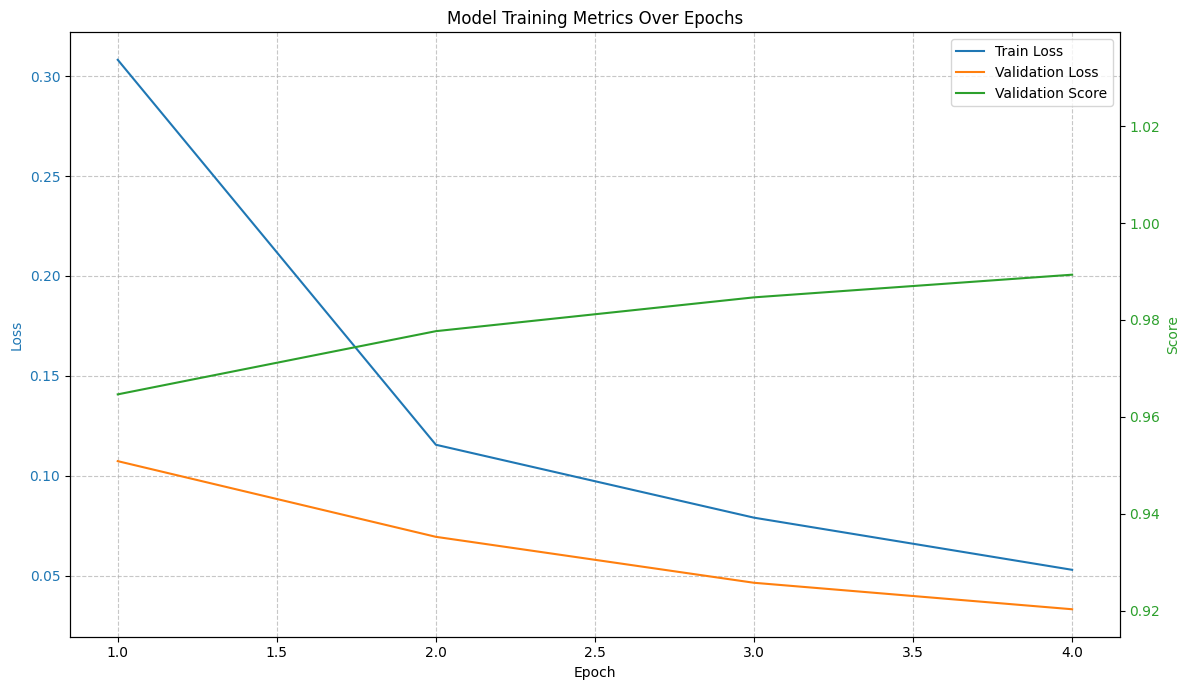

In [ ]:
plot.draw_loss(model_path='./models/checkpoints/')

## 4 测试：生成预测标签文件

In [ ]:
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class NewsTestDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_seq_length=48):
        """
        测试集数据集（无标签）
        Args:
            csv_path: 测试集CSV路径（test.csv）
            tokenizer: BertTokenizer实例
            max_seq_length: 文本最大长度
        """
        # 读取CSV，仅保留text_a列（无label列）
        self.df = pd.read_csv(csv_path, sep='\t')
        # 过滤无效文本（非空且为字符串）
        self.df = self.df.dropna(subset=['text_a']).reset_index(drop=True)
        # 记录原始索引（确保输出顺序与输入一致）
        self.df['original_idx'] = self.df.index
        
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """返回：文本的tokenize结果 + 原始索引（用于恢复顺序）"""
        text_a = self.df.iloc[idx]['text_a'].strip()
        original_idx = self.df.iloc[idx]['original_idx']  # 保留原始索引
        
        # Tokenize处理（与训练集一致）
        encoding = self.tokenizer(
            text_a,
            max_length=self.max_seq_length,
            padding=False,
            truncation=True,
            return_tensors=None
        )
        
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'original_idx': original_idx  # 传递原始索引
        }

In [ ]:
# ---------------------- 1. 加载必要组件 ----------------------
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
import os
from Learner.trainers.text_classify_trainer import TextClassifyTrainer

# 初始化Tokenizer（与训练时一致）
tokenizer = BertTokenizer.from_pretrained("./models/chinese-roberta-wwm-ext")

# 初始化模型（仅需结构，权重会在predict方法中加载）
model = BertForSequenceClassification.from_pretrained(
    "./models/chinese-roberta-wwm-ext",
    num_labels=14,
    return_dict=True
)

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./models/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 测试集专用collate_fn（无需处理labels）
def test_collate_fn(batch):
    """批量处理测试集数据，保持原始索引对应"""
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    original_idx = [item['original_idx'] for item in batch]  # 收集原始索引
    
    # Padding处理（与训练集一致）
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'original_idx': torch.tensor(original_idx, dtype=torch.long)
    }

In [ ]:
# 验证id2label完整性（必须包含14个类别）
assert len(id2label) == 14, f"id2label需包含14个类别，当前仅{len(id2label)}个"

# ---------------------- 2. 加载测试集 ----------------------
test_csv_path = "./data/news_datasets/test.csv"  # 你的测试集路径
max_seq_length = 48  # 与训练时一致

# 创建测试集Dataset和DataLoader
test_dataset = NewsTestDataset(
    csv_path=test_csv_path,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,  # 可根据显存调整（建议与训练时一致或更小）
    shuffle=False,  # 测试集禁止shuffle，保证顺序
    collate_fn=test_collate_fn
)

print(f"测试集共 {len(test_dataset)} 个样本")

# ---------------------- 3. 初始化Trainer并执行预测 ----------------------
# 初始化Trainer（无需传入train/dev_dataloader，仅需模型和保存路径）
trainer = TextClassifyTrainer(
    model=model,
    model_path='./models/checkpoints/',  # 模型权重保存路径（需与训练时一致）
)

# 执行预测（自动加载best_model.pth，生成result.txt）
trainer.predict(
    best_model_path='./models/checkpoints/checkpoint_4.pth',
    test_dataloader=test_dataloader,
    id2label=id2label,
    result_path='result.txt'  # 输出结果路径
)

测试集共 83599 个样本
使用 GPU: NVIDIA GeForce RTX 2080 Ti
已加载最佳模型权重：./models/checkpoints/checkpoint_4.pth


模型预测: 100%|██████████| 2613/2613 [01:21<00:00, 32.06it/s]


预测完成！共处理 83599 个样本，结果已保存到：result.txt


['科技',
 '时政',
 '科技',
 '股票',
 '股票',
 '房产',
 '时政',
 '体育',
 '科技',
 '时尚',
 '时政',
 '科技',
 '科技',
 '科技',
 '体育',
 '房产',
 '股票',
 '科技',
 '股票',
 '社会',
 '娱乐',
 '股票',
 '体育',
 '房产',
 '娱乐',
 '体育',
 '时政',
 '时政',
 '股票',
 '科技',
 '股票',
 '股票',
 '股票',
 '家居',
 '科技',
 '科技',
 '体育',
 '科技',
 '股票',
 '股票',
 '社会',
 '股票',
 '股票',
 '家居',
 '教育',
 '体育',
 '家居',
 '股票',
 '教育',
 '股票',
 '教育',
 '体育',
 '体育',
 '科技',
 '家居',
 '体育',
 '娱乐',
 '股票',
 '教育',
 '科技',
 '时政',
 '体育',
 '科技',
 '游戏',
 '科技',
 '财经',
 '体育',
 '家居',
 '时政',
 '游戏',
 '科技',
 '房产',
 '科技',
 '科技',
 '社会',
 '社会',
 '科技',
 '股票',
 '娱乐',
 '科技',
 '股票',
 '教育',
 '科技',
 '体育',
 '游戏',
 '娱乐',
 '体育',
 '教育',
 '股票',
 '科技',
 '彩票',
 '体育',
 '体育',
 '娱乐',
 '家居',
 '体育',
 '社会',
 '体育',
 '财经',
 '游戏',
 '股票',
 '股票',
 '科技',
 '股票',
 '股票',
 '科技',
 '股票',
 '科技',
 '娱乐',
 '教育',
 '房产',
 '股票',
 '财经',
 '时政',
 '体育',
 '娱乐',
 '房产',
 '社会',
 '娱乐',
 '房产',
 '科技',
 '体育',
 '游戏',
 '社会',
 '科技',
 '时政',
 '体育',
 '股票',
 '财经',
 '股票',
 '体育',
 '科技',
 '财经',
 '娱乐',
 '社会',
 '体育',
 '教育',
 '财经',
 '财经',
 '股票',
 '股票',
 '科技',
 '科技',

In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 5 评测

In [ ]:
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

In [ ]:
# ---------------------- 带标签评估集加载逻辑 ----------------------
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# 1. 初始化Tokenizer（与训练时一致）
tokenizer = BertTokenizer.from_pretrained("./models/chinese-roberta-wwm-ext")

# 2. 定义label2id和id2label（与训练时完全一致）
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育',
              '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6,
            '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居',
            7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

# 3. 加载带标签的评估集CSV（需包含text_a和label两列）
eval_csv_path = "./data/news_datasets/dev.csv"  # 你的带标签评估集路径
max_seq_length = 48  # 与训练时一致

# 4. 使用训练集的NewsDataset（已支持标签处理）


class NewsDataset(Dataset):
    def __init__(self, csv_path, tokenizer, label2id, max_seq_length=48):
        self.df = pd.read_csv(csv_path, sep='\t')
        self.df = self.df.dropna(subset=['text_a', 'label']).reset_index(
            drop=True)  # 过滤空文本/空标签
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text_a = self.df.iloc[idx]['text_a'].strip()
        label = self.df.iloc[idx]['label']
        label_id = self.label2id[label]  # 转换为类别ID

        # Tokenize（与训练时完全一致）
        encoding = self.tokenizer(
            text_a,
            max_length=self.max_seq_length,
            truncation=True,
            padding=False,
            return_tensors=None
        )

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label_id, dtype=torch.long)  # 带标签
        }

# 5. 评估集collate_fn（与训练时一致）


def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Padding处理
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


# 6. 创建评估集DataLoader
eval_dataset = NewsDataset(
    csv_path=eval_csv_path,
    tokenizer=tokenizer,
    label2id=label2id,
    max_seq_length=max_seq_length
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=32,  # 可根据显存调整
    shuffle=False,  # 评估集禁止shuffle
    collate_fn=collate_fn
)

print(f"评估集共 {len(eval_dataset)} 个样本")

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


评估集共 80000 个样本


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./models/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


使用 GPU: NVIDIA GeForce RTX 2080 Ti
已加载最佳模型权重：./models/checkpoints/checkpoint_4.pth


模型评估: 100%|██████████| 2500/2500 [01:15<00:00, 33.14it/s]


评估结果汇总（共 80000 个样本）
整体准确率：0.9893
0.9893375


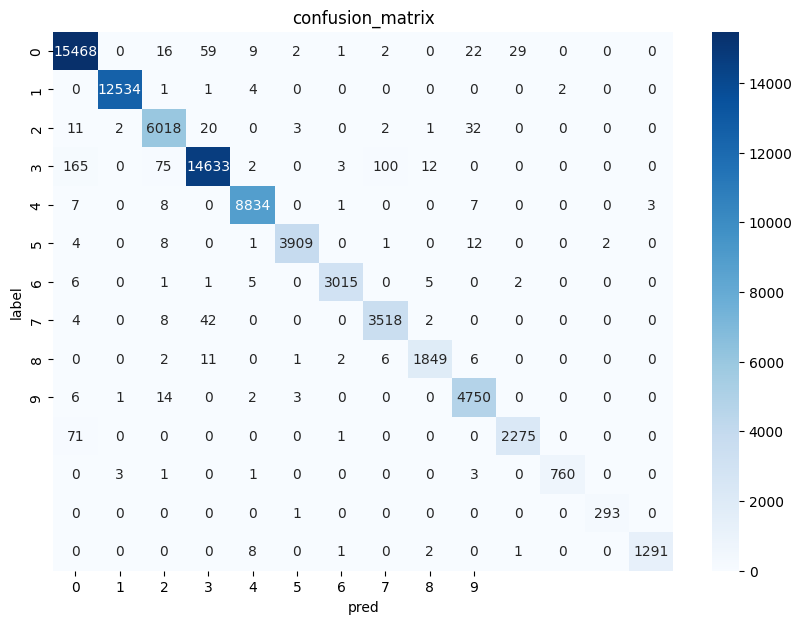

In [ ]:
# ---------------------- 初始化Trainer并执行评估 ----------------------
from transformers import BertForSequenceClassification
from Learner.trainers.text_classify_trainer import TextClassifyTrainer
from Learner.utils.plot import conf_matrix

# 1. 初始化模型（仅需结构，权重会在eval方法中加载）
model = BertForSequenceClassification.from_pretrained(
    "./models/chinese-roberta-wwm-ext",
    num_labels=14,
    return_dict=True
)

# 2. 初始化Trainer
trainer = TextClassifyTrainer(
    model=model,
    model_path='./models/checkpoints/',  # 模型权重保存路径（与训练时一致）
)

# 3. 执行评估（输出指标+保存报告+绘制混淆矩阵）
eval_metrics = trainer.eval(
    best_model_path='./models/checkpoints/checkpoint_4.pth',
    eval_dataloader=eval_dataloader,
    id2label=id2label
)

# 4. 查看关键指标（例如，查看"财经"类的性能）
# finance_label_name = "财经"
# finance_id = label2id[finance_label_name]
# print(f"\n{finance_label_name}类性能：")
# print(f"  精确率：{eval_metrics['class_accuracy'][finance_label_name]:.4f}")  # 预测为该类的样本中，真实是该类的比例
# print(f"  召回率：{eval_metrics['class_recall'][finance_label_name]:.4f}")    # 真实是该类的样本中，被正确预测的比例
# print(f"  F1-score：{eval_metrics['class_f1'][finance_label_name]:.4f}")
print(eval_metrics["overall_accuracy"])
conf_matrix(eval_metrics["confusion_matrix"])

## 6 LoRA 微调

### 6.1 数据集构建

In [ ]:
# 类别列表
# label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

In [ ]:
# ---------------------- 1. 自动提取14个类别标签（无需手动定义） ----------------------
# def get_label_list(train_csv_path="./data/news_datasets/train.csv"):
#     """从训练集CSV中自动提取所有唯一标签，生成label_list和标签映射"""
#     if not os.path.exists(train_csv_path):
#         raise FileNotFoundError(f"训练集文件 {train_csv_path} 不存在，请检查路径")
    
#     # 读取训练集，获取所有标签
#     train_df = pd.read_csv(train_csv_path, sep='\t')  # 按制表符分隔
#     label_list = train_df['label'].unique().tolist()  # 自动提取唯一标签
#     label2id = {label: idx for idx, label in enumerate(label_list)}  # 标签→ID映射
#     id2label = {idx: label for idx, label in enumerate(label_list)}  # ID→标签映射
    
#     print(f"共提取到 {len(label_list)} 个类别：{label_list}")
#     return label_list, label2id, id2label

# label_list, label2id, id2label = get_label_list()
# print(label_list)
# print(label2id)
# print(id2label)

In [ ]:
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

In [ ]:
# ---------------------- 2. 数据集类（适配CSV文件，兼容训练/验证集） ----------------------
class NewsDataset(Dataset):
    def __init__(self, csv_path, tokenizer, label2id, max_seq_length=48):
        """
        Args:
            csv_path: 数据集CSV文件路径（train.csv/dev.csv）
            tokenizer: BertTokenizer实例
            label2id: 标签→ID映射字典
            max_seq_length: 文本最大截断/补全长度（按你的分析设为48）
        """
        # 读取CSV文件（制表符分隔，第一行为表头）
        self.df = pd.read_csv(csv_path, sep='\t')
        # 过滤无效数据（确保text_a和label列存在且非空）
        self.df = self.df.dropna(
            subset=['text_a', 'label']).reset_index(drop=True)

        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_seq_length = max_seq_length

    def __len__(self):
        """返回数据集总条数"""
        return len(self.df)

    def __getitem__(self, idx):
        """按索引获取单条数据，完成Tokenize和标签转换"""
        # 提取文本和标签
        text_a = self.df.iloc[idx]['text_a'].strip()
        label = self.df.iloc[idx]['label'].strip()

        # Tokenize处理（生成input_ids、attention_mask、token_type_ids）
        encoding = self.tokenizer(
            text_a,
            max_length=self.max_seq_length,
            padding=False,  # 暂不padding，在collate_fn中统一处理（更高效）
            truncation=True,
            return_tensors=None  # 返回列表格式，方便后续pad
        )

        # 标签转换为ID（数值型）
        label_id = self.label2id[label]

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(encoding['token_type_ids'], dtype=torch.long),
            'labels': torch.tensor(label_id, dtype=torch.long)
        }

In [ ]:
# ---------------------- 3. 自定义Collate_fn（将一个批次内的所有样本，统一处理成该批次内的 “最长样本长度”） ----------------------
# 模型要求：神经网络需要 “同批次样本长度一致” 才能并行计算（否则无法矩阵运算），所以必须统一批次内的长度
# 显存优化：如果不管样本实际长度，都强制补到max_seq_length，会导致大量短样本被补无用的 padding，浪费显存；而按 “批次最长长度” 补，能最大限度减少无用 padding，节省显存
def collate_fn(batch_samples, pad_token_id=0):
    """
    批次数据处理：将单个样本拼接成批次，统一补全padding
    对应Paddle中的batchify_fn功能
    """
    # 提取批次中各字段的列表
    input_ids_list = [sample['input_ids'] for sample in batch_samples]
    attention_mask_list = [sample['attention_mask'] for sample in batch_samples]
    token_type_ids_list = [sample['token_type_ids'] for sample in batch_samples]
    labels_list = [sample['labels'] for sample in batch_samples]
    
    # 对序列进行padding（按批次中最长序列对齐）
    padded_input_ids = pad_sequence(
        input_ids_list, batch_first=True, padding_value=pad_token_id
    )
    padded_attention_mask = pad_sequence(
        attention_mask_list, batch_first=True, padding_value=0  # attention_mask pad 0
    )
    padded_token_type_ids = pad_sequence(
        token_type_ids_list, batch_first=True, padding_value=0  # token_type_ids pad 0
    )
    # 标签拼接成批次
    batch_labels = torch.stack(labels_list, dim=0)
    
    return {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_mask,
        'token_type_ids': padded_token_type_ids,
        'labels': batch_labels
    }

In [ ]:
# ---------------------- 4. DataLoader构建（对应Paddle的create_dataloader） ----------------------
def create_dataloader(
    csv_path, tokenizer, label2id, max_seq_length=48, batch_size=256, mode='train'
):
    """
    构建DataLoader迭代器
    Args:
        mode: 'train'（训练集，打乱）/'dev'（验证集，不打乱）
    """
    # 构建数据集实例
    dataset = NewsDataset(
        csv_path=csv_path,
        tokenizer=tokenizer,
        label2id=label2id,
        max_seq_length=max_seq_length
    )
    
    # 构建Sampler（训练集打乱，验证集不打乱）
    shuffle = True if mode == 'train' else False
    
    # 构建DataLoader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,  # 自定义批次处理函数
        num_workers=2,  # 多线程加载（根据CPU核心数调整，0为单线程）
        pin_memory=True  # 加速GPU训练（如果使用GPU）
    )
    
    return dataloader

### 6.2 准备工作

In [ ]:
from transformers import BertTokenizer

# 初始化Tokenizer（与本地BERT模型匹配）
tokenizer = BertTokenizer.from_pretrained("./models/chinese-roberta-wwm-ext")

# 参数设置
batch_size = 512  # LoRA显存占用更低，可尝试调大
max_seq_length = 48  # 按文本长度分析结果设置

# 固定随机种子便于结果的复现
seed = 1024
# random.seed(seed)  # Python 原生随机数
np.random.seed(seed)  # NumPy 随机数
torch.manual_seed(seed)  # PyTorch CPU 随机数种子

# 构建训练集和验证集DataLoader
train_dataloader = create_dataloader(
    csv_path="./data/news_datasets/train.csv",
    tokenizer=tokenizer,
    label2id=label2id,
    max_seq_length=max_seq_length,
    batch_size=batch_size,
    mode='train'
)

dev_dataloader = create_dataloader(
    csv_path="./data/news_datasets/dev.csv",
    tokenizer=tokenizer,
    label2id=label2id,
    max_seq_length=max_seq_length,
    batch_size=batch_size,
    mode='dev'
)

# 验证数据格式（打印批次信息）
print(f"\n训练集批次数量：{len(train_dataloader)}")
print(f"验证集批次数量：{len(dev_dataloader)}")

# 查看单批次数据
for batch in train_dataloader:
    print(f"\n批次input_ids形状：{batch['input_ids'].shape}")  # (batch_size, max_seq_length)
    print(f"批次input_ids示例：{batch['input_ids']}")
    print(f"批次attention_mask形状：{batch['attention_mask'].shape}")
    print(f"批次attention_mask示例：{batch['attention_mask']}")
    print(f"批次labels形状：{batch['labels'].shape}")
    print(f"批次labels示例：{batch['labels'][:10]}")  # 前10个样本的标签ID
    break

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



训练集批次数量：1470
验证集批次数量：157

批次input_ids形状：torch.Size([512, 27])
批次input_ids示例：tensor([[ 101, 2791, 1958,  ...,    0,    0,    0],
        [ 101, 3777, 1266,  ...,  102,    0,    0],
        [ 101, 8391, 4035,  ...,  102,    0,    0],
        ...,
        [ 101, 7270, 3736,  ...,    0,    0,    0],
        [ 101, 2802, 2339,  ...,    0,    0,    0],
        [ 101, 6205, 5966,  ...,    0,    0,    0]])
批次attention_mask形状：torch.Size([512, 27])
批次attention_mask示例：tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
批次labels形状：torch.Size([512])
批次labels示例：tensor([ 6,  8,  1,  0, 13,  9,  7,  9,  0,  1])


### 6.3 设置 Fine-Tune 优化策略，接入评价指标

选择线性预热+线性退火的动态学习率调度器，下面绘制一下学习率变化曲线：

In [ ]:
from transformers import BertForSequenceClassification, get_scheduler
from peft import LoraConfig, get_peft_model, TaskType  # LoRA核心工具
from Learner.utils import lr, plot
from torch.optim import AdamW

# -------------------------- LoRA核心配置 --------------------------
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # 任务类型：序列分类
    r=8,  # LoRA秩（低秩矩阵维度，常用8/16/32，越小参数量越少）
    lora_alpha=32,  # 缩放因子（alpha = r * 4 是经验值，平衡梯度）
    target_modules=["query", "key", "value"],  # 目标模块（RoBERTa的注意力层Q/K/V）
    lora_dropout=0.05,  # LoRA层dropout率（防止过拟合）
    bias="none",  # 是否训练bias参数（none：不训练，兼容全量微调逻辑）
    modules_to_save=["classifier"],  # 额外保存/训练的模块（分类头必须训练，否则无法适配下游任务）
    inference_mode=False  # 训练模式（False=训练，True=推理）
)

# -------------------------- 初始化模型+应用LoRA --------------------------
# 1. 加载原始RoBERTa模型（与全量微调一致）
model = BertForSequenceClassification.from_pretrained(
    "./models/chinese-roberta-wwm-ext",
    num_labels=14,
    return_dict=True
)

# 2. 冻结主干网络参数（仅训练LoRA层和分类头）
for param in model.base_model.parameters():
    param.requires_grad = False  # 冻结RoBERTa主干

# 3. 应用LoRA配置到模型
model = get_peft_model(model, lora_config)

# 4. 查看训练参数占比（验证LoRA效果）
model.print_trainable_parameters()
# 输出示例：trainable params: 196,608 || all params: 102,267,392 || trainable%: 0.192%
# 仅训练0.2%左右的参数，显存占用大幅降低！

# -------------------------- 定义超参数 --------------------------
# 超参数（LoRA训练可适当提高学习率，因为仅训练少量参数）
learning_rate = 1e-4  # 全量微调是4e-5，LoRA可提升至1e-4~2e-4（收敛更快）
# 训练轮次
epochs = 4
# 学习率预热比例（总步数的 10% 用于预热）
warmup_proportion = 0.1
# 权重衰减系数（正则项，避免过拟合）
weight_decay = 0.01  # 仅作用于训练的参数（LoRA+分类头）

# -------------------------- 计算总训练步数 --------------------------
num_training_steps = len(train_dataloader) * epochs
# 预热步数 = 总步数 × 预热比例
warmup_steps = int(num_training_steps * warmup_proportion)
# 衰减步数 = 总步数 - 预热步数
decay_steps = num_training_steps - warmup_steps

# -------------------------- 初始化优化器与学习率调度器 --------------------------
optimizer = AdamW(
    params=[
        # 应用权重衰减的参数（LoRA层+分类头的非bias/norm）
        {"params": [p for n, p in model.named_parameters() if p.requires_grad and not any(nd in n for nd in ["bias", "norm"])], 
         "weight_decay": weight_decay},
        # 不应用权重衰减的参数（bias/norm）
        {"params": [p for n, p in model.named_parameters() if p.requires_grad and any(nd in n for nd in ["bias", "norm"])], 
         "weight_decay": 0.0}
    ],
    lr=learning_rate,
    betas=(0.9, 0.999),
    eps=1e-8
)

lr_scheduler = get_scheduler(
    name="linear",  # 线性衰减
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,  # 预热步数
    num_training_steps=num_training_steps  # 总步数
)

# 绘制学习率曲线
# plot.draw_lr(
#     optimizer=optimizer,
#     scheduler=lr_scheduler,
#     total_steps=num_training_steps,
#     # label="WarmUp + Cosine Annealing"
# )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./models/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 453,134 || all params: 102,731,548 || trainable%: 0.4411


### 6.4 开始训练

In [ ]:
from Learner.trainers.text_classify_trainer import TextClassifyTrainer

trainer = TextClassifyTrainer(
    model,  # 模型
    train_dataloader=train_dataloader,  # 训练集加载器
    dev_dataloader=dev_dataloader,  # 发展集加载器：有无发展集均可
    criterion=None,  # 损失函数
    optimizer=optimizer,  # 优化器
    scheduler=lr_scheduler,  # 学习率调度器
    batch_size=batch_size,  # 样本批量
    total_epochs=epochs,  # 预期总训练轮数
    model_path='./models/checkpoints/',  # 模型检查点保存路径
    use_fp16=True
)

使用 GPU: NVIDIA GeForce RTX 2080 Ti


In [ ]:
# 开始训练（epoch_num可根据需求调整，LoRA通常3~5轮足够收敛）
trainer.fit(
    epoch_num=4,
    pretrain=0,
)

无预训练模型，从零开始训练 . . .


模型验证: 100%|██████████| 157/157 [00:18<00:00,  8.58it/s]


第 1 轮训练结束，训练集 loss 为 0.6666680569551429，发展集 loss 为 0.22385809195649092，发展集评分为 0.930975


模型验证: 100%|██████████| 157/157 [00:18<00:00,  8.36it/s]


第 2 轮训练结束，训练集 loss 为 0.21953519486448392，发展集 loss 为 0.17694761006125978，发展集评分为 0.9446375


模型验证: 100%|██████████| 157/157 [00:18<00:00,  8.63it/s]


第 3 轮训练结束，训练集 loss 为 0.194531653973521，发展集 loss 为 0.1654778352588605，发展集评分为 0.94715


模型验证: 100%|██████████| 157/157 [00:18<00:00,  8.38it/s]


第 4 轮训练结束，训练集 loss 为 0.18512805966394288，发展集 loss 为 0.16143580326798615，发展集评分为 0.9485875
保存模型到 ./models/checkpoints/checkpoint_4.pth


显示模型结构和训练过程

检测到验证集指标，将绘制完整曲线
./models/checkpoints/checkpoint_4.pth


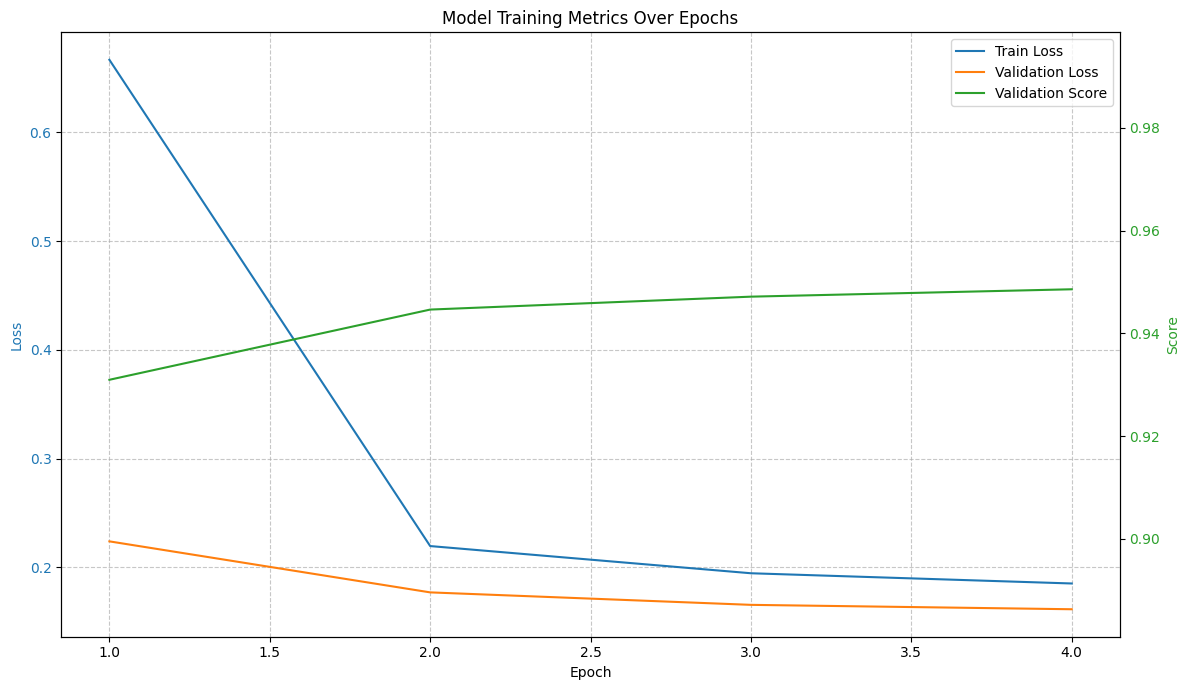

In [ ]:
plot.draw_loss(model_path='./models/checkpoints/')

In [ ]:
# -------------------------- 保存LoRA模型（关键！仅保存增量参数）--------------------------
# 保存LoRA适配器（仅几MB，无需保存完整RoBERTa模型）
model.save_pretrained("./models/lora_roberta_news")
print("LoRA模型保存完成！路径：./models/lora_roberta_news")

LoRA模型保存完成！路径：./models/lora_roberta_news


### 6.5 生成预测标签文件

In [ ]:
label_list = ['科技', '体育', '时政', '股票', '娱乐', '教育', '家居', '财经', '房产', '社会', '游戏', '彩票', '星座', '时尚']
label2id = {'科技': 0, '体育': 1, '时政': 2, '股票': 3, '娱乐': 4, '教育': 5, '家居': 6, '财经': 7, '房产': 8, '社会': 9, '游戏': 10, '彩票': 11, '星座': 12, '时尚': 13}
id2label = {0: '科技', 1: '体育', 2: '时政', 3: '股票', 4: '娱乐', 5: '教育', 6: '家居', 7: '财经', 8: '房产', 9: '社会', 10: '游戏', 11: '彩票', 12: '星座', 13: '时尚'}

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class NewsTestDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_seq_length=48):
        """
        测试集数据集（无标签）
        Args:
            csv_path: 测试集CSV路径（test.csv）
            tokenizer: BertTokenizer实例
            max_seq_length: 文本最大长度
        """
        # 读取CSV，仅保留text_a列（无label列）
        self.df = pd.read_csv(csv_path, sep='\t')
        # 过滤无效文本（非空且为字符串）
        self.df = self.df.dropna(subset=['text_a']).reset_index(drop=True)
        # 记录原始索引（确保输出顺序与输入一致）
        self.df['original_idx'] = self.df.index
        
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """返回：文本的tokenize结果 + 原始索引（用于恢复顺序）"""
        text_a = self.df.iloc[idx]['text_a'].strip()
        original_idx = self.df.iloc[idx]['original_idx']  # 保留原始索引
        
        # Tokenize处理（与训练集一致）
        encoding = self.tokenizer(
            text_a,
            max_length=self.max_seq_length,
            padding=False,
            truncation=True,
            return_tensors=None
        )
        
        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'original_idx': original_idx  # 传递原始索引
        }

In [ ]:
# ---------------------- 1. 加载必要组件 ----------------------
from transformers import BertTokenizer, BertForSequenceClassification
from peft import PeftModel, PeftConfig
from Learner.trainers.text_classify_trainer import TextClassifyTrainer

# 1. 加载LoRA配置
peft_config = PeftConfig.from_pretrained("./models/lora_roberta_news")

# 2. 加载原始RoBERTa模型（与训练时一致）
base_model = BertForSequenceClassification.from_pretrained(
    "./models/chinese-roberta-wwm-ext",
    num_labels=14,
    return_dict=True
)

# 3. 加载LoRA适配器（合并到原始模型）
model = PeftModel.from_pretrained(base_model, "./models/lora_roberta_news")

# 4. 切换为推理模式
model.eval()
tokenizer = BertTokenizer.from_pretrained("./models/chinese-roberta-wwm-ext")

/home/mm/miniconda3/envs/ykz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./models/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 测试集专用collate_fn（无需处理labels）
def test_collate_fn(batch):
    """批量处理测试集数据，保持原始索引对应"""
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    original_idx = [item['original_idx'] for item in batch]  # 收集原始索引
    
    # Padding处理（与训练集一致）
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        attention_mask, batch_first=True, padding_value=0
    )
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'original_idx': torch.tensor(original_idx, dtype=torch.long)
    }

In [ ]:
# 验证id2label完整性（必须包含14个类别）
assert len(id2label) == 14, f"id2label需包含14个类别，当前仅{len(id2label)}个"

# ---------------------- 2. 加载测试集 ----------------------
test_csv_path = "./data/news_datasets/test.csv"  # 你的测试集路径
max_seq_length = 48  # 与训练时一致

# 创建测试集Dataset和DataLoader
test_dataset = NewsTestDataset(
    csv_path=test_csv_path,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,  # 可根据显存调整（建议与训练时一致或更小）
    shuffle=False,  # 测试集禁止shuffle，保证顺序
    collate_fn=test_collate_fn
)

print(f"测试集共 {len(test_dataset)} 个样本")

# ---------------------- 3. 初始化Trainer并执行预测 ----------------------
# 初始化Trainer（无需传入train/dev_dataloader，仅需模型和保存路径）
trainer = TextClassifyTrainer(
    model=model,
    model_path='./models/checkpoints/',  # 模型权重保存路径（需与训练时一致）
)

# 执行预测（自动加载best_model.pth，生成result.txt）
trainer.predict(
    best_model_path='./models/checkpoints/checkpoint_4.pth',
    test_dataloader=test_dataloader,
    id2label=id2label,
    result_path='result.txt'  # 输出结果路径
)

测试集共 83599 个样本
使用 GPU: NVIDIA GeForce RTX 2080 Ti


模型预测: 100%|██████████| 2613/2613 [01:55<00:00, 22.66it/s]

预测完成！共处理 83599 个样本，结果已保存到：result.txt


['科技',
 '时政',
 '科技',
 '股票',
 '股票',
 '房产',
 '时政',
 '体育',
 '科技',
 '财经',
 '时政',
 '科技',
 '科技',
 '科技',
 '体育',
 '房产',
 '股票',
 '科技',
 '股票',
 '社会',
 '娱乐',
 '股票',
 '体育',
 '房产',
 '娱乐',
 '体育',
 '时政',
 '时政',
 '股票',
 '科技',
 '股票',
 '股票',
 '财经',
 '家居',
 '科技',
 '科技',
 '体育',
 '科技',
 '股票',
 '股票',
 '社会',
 '股票',
 '股票',
 '家居',
 '教育',
 '体育',
 '家居',
 '股票',
 '体育',
 '股票',
 '时政',
 '体育',
 '体育',
 '科技',
 '家居',
 '体育',
 '娱乐',
 '股票',
 '教育',
 '科技',
 '时政',
 '体育',
 '科技',
 '游戏',
 '科技',
 '财经',
 '体育',
 '家居',
 '时政',
 '游戏',
 '时政',
 '房产',
 '科技',
 '科技',
 '时政',
 '社会',
 '科技',
 '股票',
 '娱乐',
 '科技',
 '股票',
 '教育',
 '科技',
 '体育',
 '游戏',
 '娱乐',
 '体育',
 '教育',
 '股票',
 '科技',
 '彩票',
 '体育',
 '体育',
 '娱乐',
 '家居',
 '娱乐',
 '社会',
 '体育',
 '财经',
 '游戏',
 '股票',
 '股票',
 '科技',
 '股票',
 '股票',
 '科技',
 '股票',
 '科技',
 '娱乐',
 '教育',
 '房产',
 '股票',
 '股票',
 '时政',
 '体育',
 '娱乐',
 '房产',
 '时政',
 '娱乐',
 '房产',
 '科技',
 '体育',
 '游戏',
 '社会',
 '科技',
 '时政',
 '体育',
 '股票',
 '财经',
 '财经',
 '体育',
 '科技',
 '股票',
 '娱乐',
 '社会',
 '体育',
 '教育',
 '财经',
 '财经',
 '股票',
 '股票',
 '时政',
 '科技',

In [ ]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(21128, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (defaul